In [1]:
from matplotlib import pyplot as plt
import tfim_1d
from TFIM_generator import generate_TFIM_gates 
from qcels import *
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService as QRS
from qiskit_ibm_runtime import SamplerV2 as Sampler
import matplotlib
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10

In [2]:
num_sites = 4
J = 1.0
g = 4

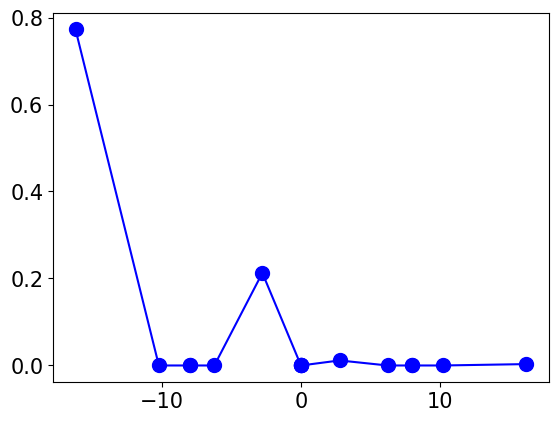

-16.255760712284413


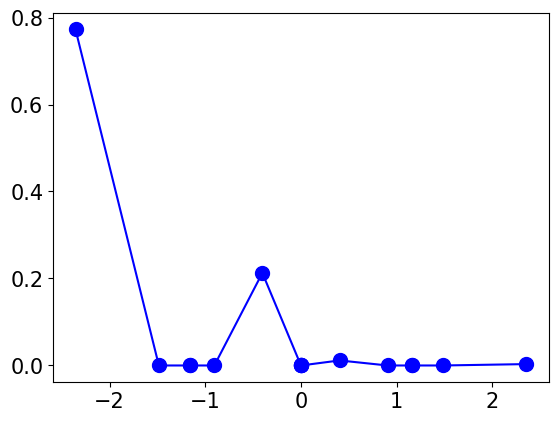

In [3]:
# calculate the ground state with g = 1
ham0 = tfim_1d.generate_ham(num_sites, J, 1.0)
ground_state_0 = ham0.eigh(subset_by_index = (0,0))[1][:,0] # g = 1 ground state


# plot original spectrum
ham = tfim_1d.generate_ham(num_sites, J, g)
eigenenergies, eigenstates = ham.eigh()
ground_state = eigenstates[:,0]
population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population_raw, 'b-o')
plt.show()
print(eigenenergies[0])

old_ham = ham

# create modified spectrum
ham = modify_spectrum(old_ham)
eigenenergies, eigenstates = eigh(ham)

ground_state = eigenstates[:,0]
population = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population, 'b-o')
plt.show()

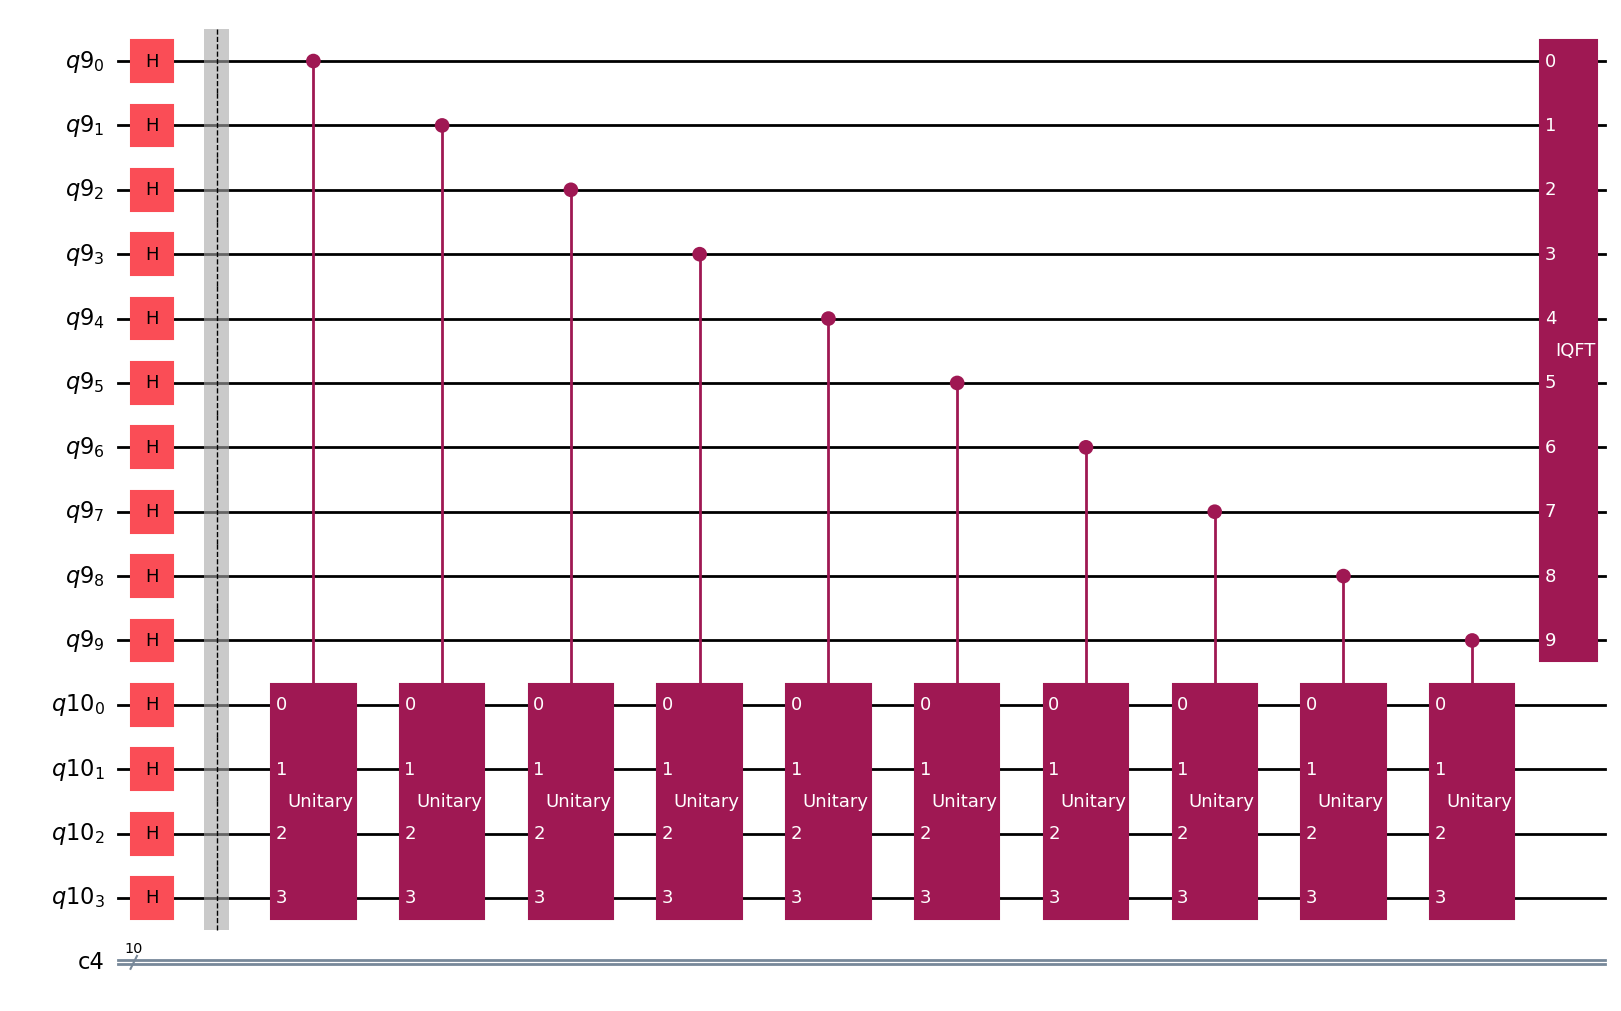

In [17]:
ancilla_bits = 10

qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(num_sites)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# prepare state
qc.h(qr_ancilla)

# the input state gets moddified here
qc.h(qr_eigenstate)


qc.barrier()

ts = np.linspace(0,1,ancilla_bits)

for i in range(ancilla_bits):
    #mat = np.linalg.matrix_power(H, 2**(i))
    mat = np.linalg.matrix_power(expm(-1j*ham), 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
qc.draw('mpl')

In [6]:
def plot_distribution(ax, angle, ancilla_bits, counts):
    ax.tick_params(axis = 'x', rotation=90)
    ax.set_ylabel("Probability")
    ax.set_xlabel("Binary String")
    ax.set_title(f"\u03C6= {angle:0.5f}")
    bin_nums = []
    shots  = 0
    for i in counts.values(): shots+=i
    for i in range(2**ancilla_bits):
        bin_nums.append(bin(int(i))[2:])
        bin_nums[i]=bin_nums[i].zfill(ancilla_bits)
    updated_counts = []
    big_prob = []
    big_prob_str = []
    for i in bin_nums:
        try:
            num = counts[i]
        except:
            num = 0
        finally:
            prob = num/shots
            updated_counts.append(prob)
            if prob >0.1:
                big_prob.append(prob)
                big_prob_str.append(i)
    bar = ax.bar(bin_nums, updated_counts)
    bar = ax.bar(big_prob_str, big_prob, width=0)
    ax.bar_label(bar, fmt=lambda x: f" {x:0.2f}", fontsize= 10, rotation=90)
    ax.set_ylim(ymax = max(updated_counts)+.11)

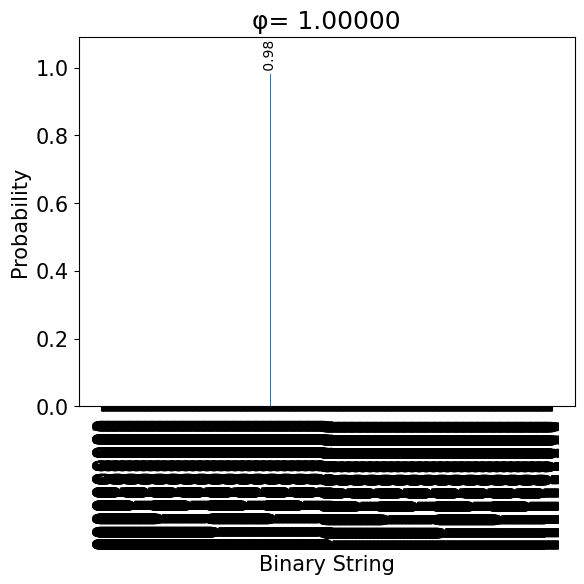

In [19]:
qc.measure(qr_ancilla, cr)

aer_sim = AerSimulator()
trans_qc = transpile(qc, aer_sim)
counts = aer_sim.run(trans_qc, shots = 10**4).result().get_counts()
fig,ax = plt.subplots(nrows = 1, ncols = 1)
plot_distribution(ax, 1, ancilla_bits, counts)
plt.show()

In [20]:
binary_num = ''
max_num = 0
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key
print("Binary Number with Maximum count:     0."+binary_num)
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i+1)
decimal_num = decimal_num*(2*np.pi)
print("Decimal Number with Equivalent Value:",decimal_num)

Binary Number with Maximum count:     0.0110000000
Decimal Number with Equivalent Value: 2.356194490192345


In [19]:
ancilla_bits = 10

qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(num_sites)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# prepare state
qc.h(qr_ancilla)

# the input state gets moddified here
qc.h(qr_eigenstate)


qc.barrier()


unitary = (generate_TFIM_gates(num_sites, 2, 1, g, '../../../f3cpp'))

for i in range(ancilla_bits):
    for _ in range(2**i):
        qc.append(unitary[1], qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
qc.measure(qr_ancilla, cr)
#qc.draw('mpl')

********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 1 , dt = 0

    hx = const value: 4
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 4, Jz = 1

********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 1 , dt = 1

    hx = const value: 4
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 4, Jz = 1



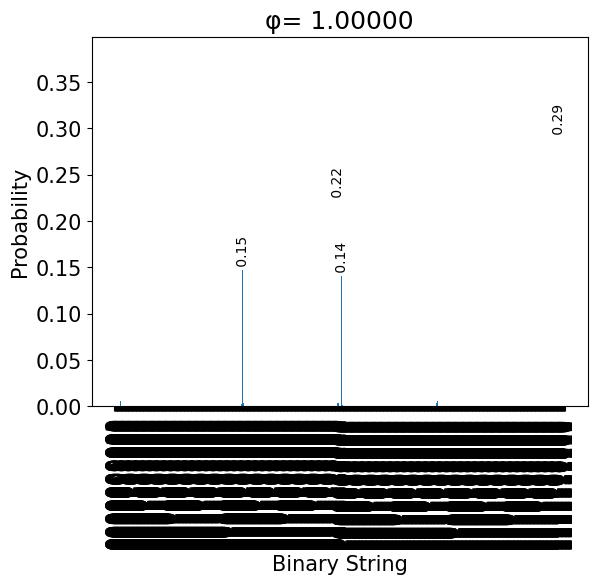

In [20]:

aer_sim = AerSimulator()
trans_qc = transpile(qc, aer_sim)
counts = aer_sim.run(trans_qc, shots = 10000).result().get_counts()
fig,ax = plt.subplots(nrows = 1, ncols = 1)
plot_distribution(ax, 1, ancilla_bits, counts)
plt.show()

In [21]:
binary_num = ''
max_num = 0
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key
print("Binary Number with Maximum count:     0."+binary_num)
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i+1)
decimal_num = -decimal_num
print("Decimal Number with Equivalent Value:",decimal_num)

Binary Number with Maximum count:     0.1111110010
Decimal Number with Equivalent Value: -0.986328125


In [4]:
computation_type = 'S'
output_file = True
p0_array            = np.array([0.9, 1]) # initial overlap with the first eigenvector
# p0_array            = np.arange(0.6, 0.99, 0.05)
trials              = 10 # number of comparisions each test (circuit depths)
tests               = 1
err_threshold       = 0.01
T0                  = 100

# QCELS variables
time_steps          = 5
epsilons            = np.array([0.1, 0.02, 0.009, 0.006, 0.003, 0.001, 0.0005, 0.0001, 0.00009, 0.00004])
iterations          = [int(np.log2(1/time_steps/i)) for i in epsilons]
err_QCELS           = np.zeros((len(p0_array),trials))
est_QCELS           = np.zeros((len(p0_array),trials))
cost_list_avg_QCELS = np.zeros((len(p0_array),trials))
rate_success_QCELS  = np.zeros((len(p0_array),trials))
max_T_QCELS         = np.zeros((len(p0_array),trials))

In [5]:
# initialization: S (Quantum Simulation), or R (Quantum Hardware)

if computation_type[0].upper() == 'S':
    print("\nQUANTUM SIMULATION SELECTED\n")

    backend = AerSimulator()
    data_name = "Q_Sim"

if computation_type[0].upper() == 'R':
    print("\nQUANTUM HARDWARE SELECTED\n")    
    
    # save qiskit API token for later use
    api_token = input("Enter API Token:")
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
    data_name = "Q_Real"

if output_file:
    outfile = open("Output/"+str(data_name)+"_trans.txt", 'w')



QUANTUM SIMULATION SELECTED



In [6]:
# Transpiles circuits
for p in range(len(p0_array)):
    p0=p0_array[p]
    n_success_QCELS= np.zeros(trials)
    n_success_QPE= np.zeros(trials)

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

    for test in range(tests):

        print("  Generating QCELS circuits", "(p0="+str(p0)+")","("+str(test+1)+"/"+str(tests)+")")

        spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0])

        #------------------QCELS-----------------
        Nsample = 100 # number of samples for constructing the loss function

        for trial in range(trials):
            print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")")
            epsilon = epsilons[trial]

            if output_file: print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)
            T = 1/epsilon
            for j in range(iterations[trial] + 1):
                tau = get_tau(j, time_steps, iterations[trial], T)
                qcs_QCELS = []
                unitaries = (generate_TFIM_gates(num_sites, time_steps, tau, g, '../../../f3cpp'))
                for data_pair in range(time_steps):
                    t = tau*data_pair
                    mat = expm(-1j*ham*t)
                    controlled_U = UnitaryGate(mat).control(annotated="yes")
                    #qcs_QCELS.append(create_HT_circuit(num_sites, unitaries[data_pair], W = 'Re', p0 = p0, backend = backend))
                    #qcs_QCELS.append(create_HT_circuit(num_sites, unitaries[data_pair], W = 'Im', p0 = p0, backend = backend))
                    qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W = 'Re', p0 = p0, backend = backend))
                    qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W = 'Im', p0 = p0, backend = backend))
                with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Test'+str(test)+'_Trial'+str(trial)+'_Iter='+str(j)+'.qpy', 'wb') as f:
                    qiskit.qpy.dump(qcs_QCELS, f)
        print('Finished transpiling for QCELS test '+str(test + 1))


Testing p0 = 0.9 (1/2)
  Generating QCELS circuits (p0=0.9) (1/1)
    Transpiling QCELS (1/10)
********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 1 , dt = 0

    hx = const value: 4
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 4, Jz = 1

********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 4 , dt = 1

    hx = const value: 4
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 4, Jz = 1
* timestep 2: hx = 4, Jz = 1
* timestep 3: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 4: hx = 4, Jz = 1
    - merge layer1
    - merge layer2

********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 1 , dt = 0

    hx = const value: 4
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 4, Jz = 1

********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 4 , dt = 2

    hx = const value: 4
    Jy = const value:

/home/aweiss/Documents/quantum-phase-estimation-comparision/Quantum_Version/qcels.py:121: RuntimeWarning: divide by zero encountered in divide
  q[0:num_p] = p/(1-np.sum(p))*np.sum(q[num_p:])
/home/aweiss/Documents/quantum-phase-estimation-comparision/Quantum_Version/qcels.py:122: RuntimeWarning: invalid value encountered in divide
  return spectrum, q/np.sum(q)


********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 1 , dt = 0

    hx = const value: 4
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 4, Jz = 1

********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 4 , dt = 2

    hx = const value: 4
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 4, Jz = 1
* timestep 2: hx = 4, Jz = 1
* timestep 3: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 4: hx = 4, Jz = 1
    - merge layer1
    - merge layer2

    Transpiling QCELS (2/10)
********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 1 , dt = 0

    hx = const value: 4
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 4, Jz = 1

********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 4 , dt = 1.25

    hx = const value: 4
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 4, Jz = 1
* time

In [7]:
# Loads transpiled circuits
QCELS_depths = []

qcs_QCELS = []

for p in range(len(p0_array)):
    p0 = p0_array[p]
    QCELS_depths.append([])
    for test in range(tests):
        QCELS_depths[p].append([])
        for trial in range(trials):
            depth = 0
            print('Loading QCELS data ('+str(trial+1)+'/'+str(trials)+')')
            for i in range(iterations[trial] + 1):
                with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Test'+str(test)+'_Trial'+str(trial)+'_Iter='+str(i)+'.qpy', 'rb') as f:
                    circs = qiskit.qpy.load(f)
                    for time_step in range(time_steps):
                        depth += circs[time_step].depth() 
                    qcs_QCELS.append(circs)

            QCELS_depths[p][test].append(depth)

qcs_QCELS = sum(qcs_QCELS, []) # flatten list

Loading QCELS data (1/10)
Loading QCELS data (2/10)
Loading QCELS data (3/10)
Loading QCELS data (4/10)
Loading QCELS data (5/10)
Loading QCELS data (6/10)
Loading QCELS data (7/10)
Loading QCELS data (8/10)
Loading QCELS data (9/10)
Loading QCELS data (10/10)
Loading QCELS data (1/10)
Loading QCELS data (2/10)
Loading QCELS data (3/10)
Loading QCELS data (4/10)
Loading QCELS data (5/10)
Loading QCELS data (6/10)
Loading QCELS data (7/10)
Loading QCELS data (8/10)
Loading QCELS data (9/10)
Loading QCELS data (10/10)


In [8]:
# Runs loaded circuits
print('Running transpiled circuits')
sampler = Sampler(backend)
jobs = sampler.run(qcs_QCELS, shots = T0)
results = jobs.result()

Running transpiled circuits


In [9]:
Z_ests = []
QCELS_times = []
init_lambdas = []
for p in range(len(p0_array)):
    Z_ests.append([])
    QCELS_times.append([])
    for test in range(tests):
        Z_ests[p].append([])
        QCELS_times[p].append([])
        for trial in range(trials):
            exec_time = 0
            Z_ests[p][test].append([])
            for iter in range(iterations[trial] + 1):
                Z_ests[p][test][trial].append([])
                for time_step in range(time_steps):
                    index = time_step*2 + iter*time_steps*2 + (sum(iterations[0:trial])+trial)*time_steps*2 + test*(sum(iterations)+len(iterations))*time_steps*2 + p*tests*(sum(iterations)+len(iterations))*time_steps*2
                    raw_data_re = results[index].data
                    counts_re = raw_data_re[list(raw_data_re.keys())[0]].get_counts()
                    raw_data_im = results[index + 1].data
                    counts_im = raw_data_im[list(raw_data_im.keys())[0]].get_counts()
                    exec_time += (0 + 1)

                    re_p0 = im_p0 = 0
                    if counts_re.get('0') is not None:
                        re_p0 = counts_re['0']/T0
                    if counts_im.get('0') is not None:
                        im_p0 = counts_im['0']/T0
                    #print('ReCounts', counts_re.get('0'), 'ImCounts', counts_im['0'])
                    
                    Re = 2*re_p0-1
                    Im = 2*im_p0-1 

                    Angle = np.arccos(Re)
                    if  np.arcsin(Im)<0:
                        Phase = 2*np.pi - Angle
                    else:
                        Phase = Angle

                    Z_est = complex(np.cos(Phase),np.sin(Phase))
                    
                    Z_ests[p][test][trial][iter].append(Z_est)
            QCELS_times[p][test].append(exec_time)

In [10]:
lambda_prior = -1

In [10]:
if output_file:
    outfile = open("Output/"+str(data_name)+"_run.txt", 'w')

for p in range(len(p0_array)):
    p0=p0_array[p]
    n_success_QCELS= np.zeros(trials)
    n_success_QPE= np.zeros(trials)

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

    for test in range(tests):

        print("  Generating QCELS and QPE data", "(p0="+str(p0)+")","("+str(test+1)+"/"+str(tests)+")")

        spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0])

        #------------------QCELS-----------------
        Nsample = 100 # number of samples for constructing the loss function

        for trial in range(trials):
            print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")")

            if output_file: print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)
            epsilon = epsilons[trial]
            T = 1/epsilon
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cosT_depth_list_this = qcels_largeoverlap_new(Z_ests[p][test][trial], time_steps, lambda_prior, T)
            #ground_energy_estimate_QCELS, cosT_depth_list_this, max_T_QCELS_this = qcels_largeoverlap()
            
            #cosT_depth_list_this = QCELS_depths[p][test][trial]
            max_T_QCELS_this = 0

            print("      Estimated ground state energy =", ground_energy_estimate_QCELS)
            if output_file: print("      Estimated ground state energy =", ground_energy_estimate_QCELS.x[2], file = outfile)

            est_this_run_QCELS = ground_energy_estimate_QCELS.x[2]
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - lambda_prior)
            err_QCELS[p,trial] = err_QCELS[p,trial]+np.abs(err_this_run_QCELS)
            est_QCELS[p,trial] = est_QCELS[p,trial] + est_this_run_QCELS
            cost_list_avg_QCELS[p,trial]=cost_list_avg_QCELS[p,trial]+cosT_depth_list_this
            max_T_QCELS[p,trial]=max(max_T_QCELS[p,trial],max_T_QCELS_this)

            if np.abs(err_this_run_QCELS)<err_threshold:
                n_success_QCELS[trial]+=1

        print("    Finished QCELS data\n")
        if output_file: print("    Finished QCELS data\n", file = outfile)

    rate_success_QCELS[p,:] = n_success_QCELS[:]/tests
    err_QCELS[p,:] = err_QCELS[p,:]/tests
    est_QCELS[p,:] = est_QCELS[p,:]/tests
    cost_list_avg_QCELS[p,:]=cost_list_avg_QCELS[p,:]/tests

np.savez('Data/'+data_name+'_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS,name5=est_QCELS)
np.savez('Data/'+data_name+'_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])

print("Saved data to files starting with", data_name)
if output_file: print("Saved data to files starting with", data_name, file = outfile, flush=True)
outfile.close()
if output_file: print("Saved output to file ", "Output/"+str(data_name)+".txt")


Testing p0 = 0.9 (1/2)
  Generating QCELS and QPE data (p0=0.9) (1/1)
    Running QCELS (1/10)
      Preprocessing
      Starting Iteration (1/1)
      Finished Iterations
      Estimated ground state energy =  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.16289389063930415
       x: [ 8.960e-01 -1.851e-01 -2.331e+00]
     nit: 9
     jac: [ 2.728e-04 -9.459e-04 -5.613e-04]
    nfev: 39
    njev: 9
    Running QCELS (2/10)
      Preprocessing
      Starting Iteration (1/3)
      Starting Iteration (2/3)
      Starting Iteration (3/3)
      Finished Iterations
      Estimated ground state energy =  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.18130607259121348
       x: [ 8.874e-01 -1.767e-01 -2.380e+00]
     nit: 5
     jac: [ 1.288e-04  4.536e-04 -1.332e-02]
    nfev: 24
    njev: 5
    Running QCELS (3/10)
      Preprocessing
      Starting Iteration (1/4)
      Starting Iteration (2/4)
      Starting Iter

/home/aweiss/Documents/quantum-phase-estimation-comparision/Quantum_Version/qcels.py:121: RuntimeWarning: divide by zero encountered in divide
  q[0:num_p] = p/(1-np.sum(p))*np.sum(q[num_p:])
/home/aweiss/Documents/quantum-phase-estimation-comparision/Quantum_Version/qcels.py:122: RuntimeWarning: invalid value encountered in divide
  return spectrum, q/np.sum(q)
